In [54]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [55]:
BATCH_SIZE = 100
IMAGE_SIZE = 516
EPOCHS=50
CHANNELS=3

In [59]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("E:/Resized  Insect 140 images/After Augmentation",
    image_size=(516, 516),
    shuffle=True,
    seed=None,
)

Found 1250 files belonging to 5 classes.


In [60]:
class_names = dataset.class_names
class_names

['Butterfly', 'Honey Bee', 'House Fly', 'Locust', 'Mosquito']

In [61]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 516, 516, 3)
[1 2 3 3 4 0 0 1 0 1 1 4 0 2 3 2 0 4 1 3 3 2 4 0 1 1 3 4 0 3 4 1]


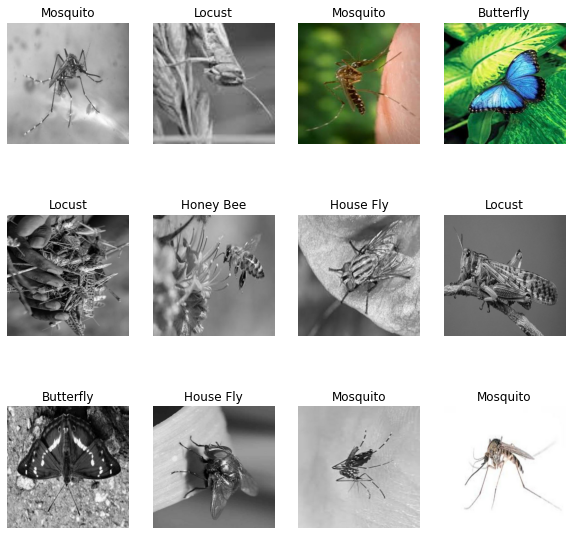

In [62]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [63]:
len(dataset)

40

In [64]:
train_size = 0.8
len(dataset)*train_size

32.0

In [65]:
test_ds = dataset.skip(32)
len(test_ds)

8

In [66]:
val_size=0.1
len(dataset)*val_size

4.0

In [70]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [71]:
test_ds = test_ds.skip(4)
len(test_ds)

0

In [72]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [73]:
len(train_ds)

32

In [74]:
len(val_ds)

4

In [75]:
len(test_ds)

4

In [76]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [77]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [78]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [79]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [80]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5


In [81]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [82]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (100, 516, 516, 3)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (100, 514, 514, 32)       896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (100, 257, 257, 32)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (100, 255, 255, 64)       18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (100, 127, 127, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (100, 125, 125, 64)       36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (100, 62, 62, 64)        

In [83]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [84]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
32/32 [==============================] - 148s 5s/step - loss: 1.6119 - accuracy: 0.2153 - val_loss: 1.5855 - val_accuracy: 0.2578
Epoch 2/50
32/32 [==============================] - 152s 5s/step - loss: 1.5899 - accuracy: 0.2334 - val_loss: 1.5693 - val_accuracy: 0.2188
Epoch 3/50
32/32 [==============================] - 157s 5s/step - loss: 1.5255 - accuracy: 0.3239 - val_loss: 1.5059 - val_accuracy: 0.3672
Epoch 4/50
32/32 [==============================] - 154s 5s/step - loss: 1.4022 - accuracy: 0.3712 - val_loss: 1.3782 - val_accuracy: 0.3828
Epoch 5/50
32/32 [==============================] - 160s 5s/step - loss: 1.3099 - accuracy: 0.4074 - val_loss: 1.3969 - val_accuracy: 0.4062
Epoch 6/50
32/32 [==============================] - 160s 5s/step - loss: 1.3311 - accuracy: 0.4074 - val_loss: 1.2855 - val_accuracy: 0.4688
Epoch 7/50
32/32 [==============================] - 162s 5s/step - loss: 1.2772 - accuracy: 0.4406 - val_loss: 1.3677 - val_accuracy: 0.4375
Epoch 8/50
32

In [85]:
history.history['loss'][:10] 

[1.6119188070297241,
 1.5899136066436768,
 1.525519847869873,
 1.4021750688552856,
 1.3098540306091309,
 1.3311302661895752,
 1.2772144079208374,
 1.2487585544586182,
 1.1908279657363892,
 1.1506894826889038]

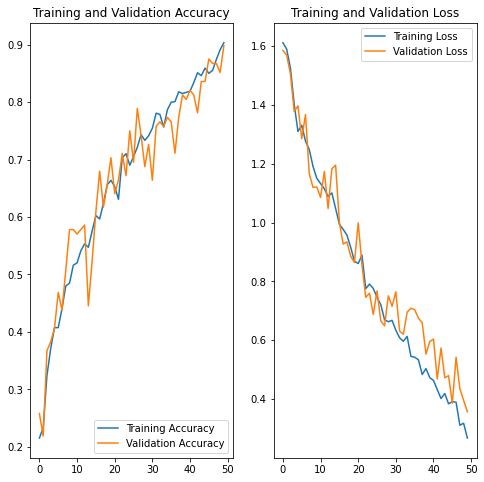

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [87]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


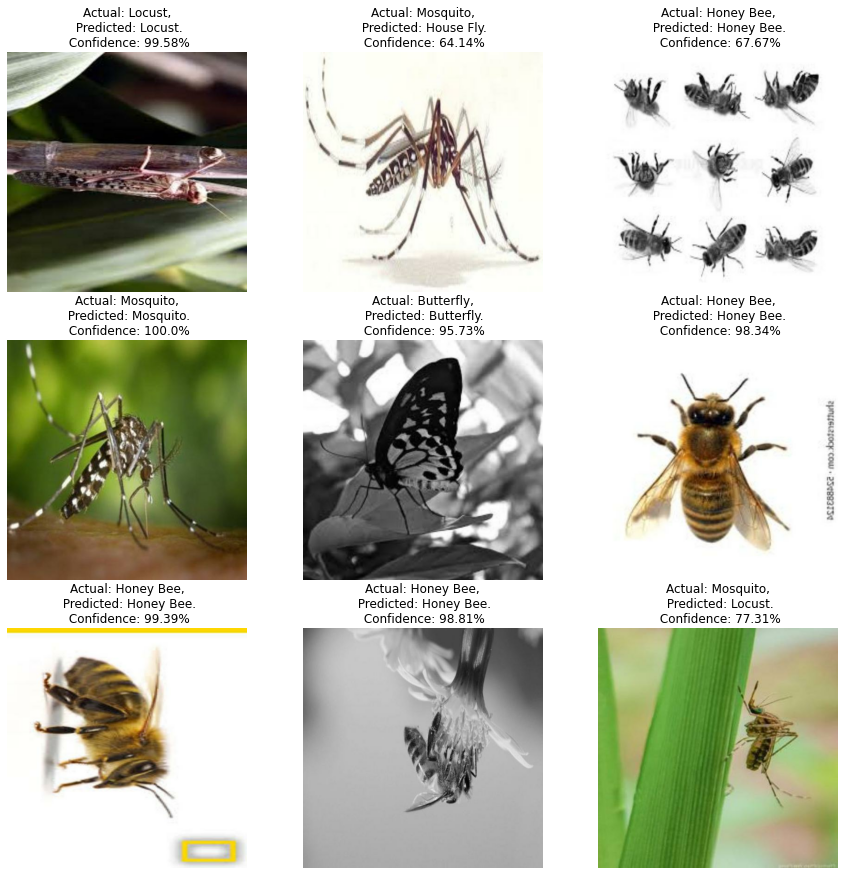

In [88]:
import numpy as np # linear algebra
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

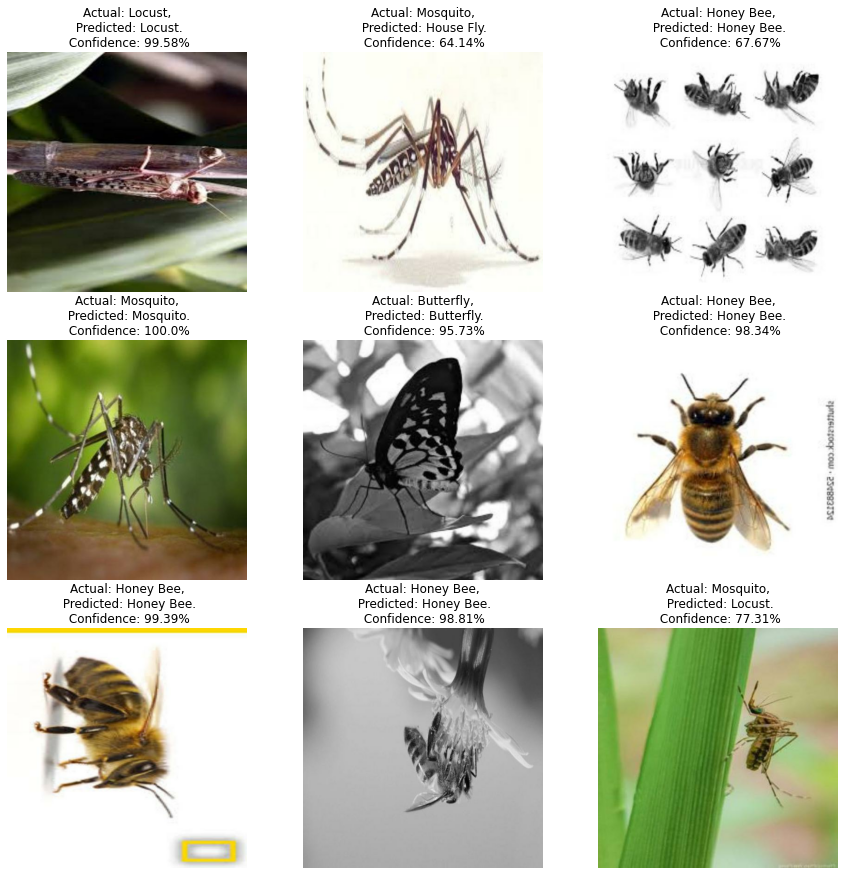

In [89]:
import numpy as np # linear algebra
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")